In [1]:
import pandas as pd
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold,cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# from category_encoders import *
import numpy as np
# from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score,recall_score
import time
import matplotlib.pyplot as plt


# #extract the data
raw_df = pd.read_csv("../BitcoinHeistData.csv")
cleaned_df = raw_df.copy()
cleaned_df['class']=np.array([0 if x=='white' else 1 for x in cleaned_df.pop('label')])

cleaned_df.pop("address")
cleaned_df.pop("year")
cleaned_df.pop("day")

eps=0.001 # 0 => 0.1¢
cleaned_df['Log income'] = np.log(cleaned_df.pop('income')+eps)
cleaned_df['Log weight'] = np.log(cleaned_df.pop('weight')+eps)
print(cleaned_df.head(5))

#summarize the data distribution
y=np.array(cleaned_df['class'])
X=np.array(cleaned_df.iloc[:,:-1])
print(Counter(y))

#rescale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


#define the undersampling method
under = RandomUnderSampler(sampling_strategy=0.5)


ModuleNotFoundError: No module named 'pandas'

['555', '556', '557', '565', '566', '567', '575', '576', '577', '655', '656', '657', '665', '666', '667', '675', '676', '677', '755', '756', '757', '765', '766', '767', '775', '776', '777']


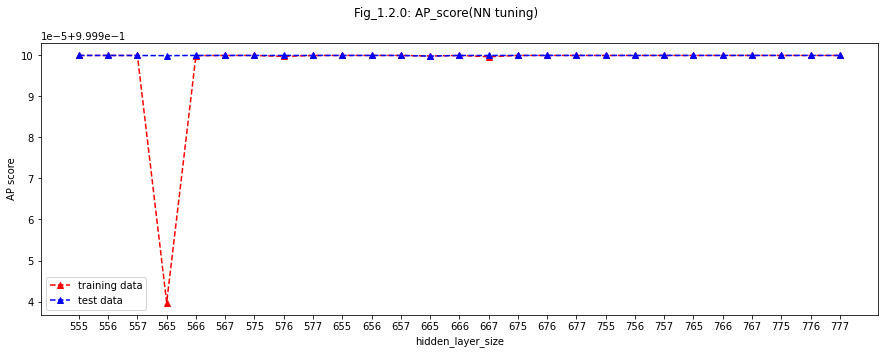

In [39]:
###########Cross-validation to find a good hidden_layer_size#################

t=7
cv = KFold(n_splits=t,shuffle=True)


##cross validation to find out the best hidden_layer_size using kd_tree###
recall_train_score_list=[]
recall_test_score_list=[]
AP_train_score_list=[]
AP_test_score_list=[]
fit_time_list=[]

hidden_layer_sizes = [(i,j,k) for i in range(5,8) for j in range(5,8) for k in range(5,8)]
for hidden_layer_size in hidden_layer_sizes:
    MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_size,activation ='tanh',solver='sgd',max_iter=200)
    steps = [('under',under),('model',MLP)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
    AP_train_score_list.append(sum(scores['train_average_precision'])/t)
    AP_test_score_list.append(sum(scores['test_average_precision'])/t)

#generate Fig_1.2.0 tunning graph#######
# m = len(hidden_layer_sizes)
hidden_layer_sizes_text=[str(hidden_layer_size[0])+str(hidden_layer_size[1])+str(hidden_layer_size[2]) for hidden_layer_size in hidden_layer_sizes]
print(hidden_layer_sizes_text)
fig_0, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
axs[0].plot(hidden_layer_sizes_text[:10],AP_train_score_list[:10],"r^",linestyle = "--",label='training data')
axs[0].plot(hidden_layer_sizes_text[:10],AP_test_score_list[:10],"b^",linestyle = "--",label='test data')
axs[1].plot(hidden_layer_sizes_text[10:21],AP_train_score_list[10:21],"r^",linestyle = "--",label='training data')
axs[1].plot(hidden_layer_sizes_text[10:21],AP_test_score_list[10:21],"b^",linestyle = "--",label='test data')
axs[2].plot(hidden_layer_sizes_text[21:],AP_train_score_list[21:],"r^",linestyle = "--",label='training data')
axs[2].plot(hidden_layer_sizes_text[21:],AP_test_score_list[21:],"b^",linestyle = "--",label='test data')
axs[0].set_xlabel("hidden_layer_size")
axs[0].set_ylabel("AP_score")
axs[1].set_xlabel("hidden_layer_size")
axs[1].set_ylabel("AP_score")
axs[2].set_xlabel("hidden_layer_size")
axs[2].set_ylabel("AP_score")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig_0.suptitle("Fig_1.2.0: AP_score(NN tuning)")
fig_0.savefig("NN_fig_1.2_tunning:AP_score.png")


AttributeError: 'AxesSubplot' object has no attribute 'plt'

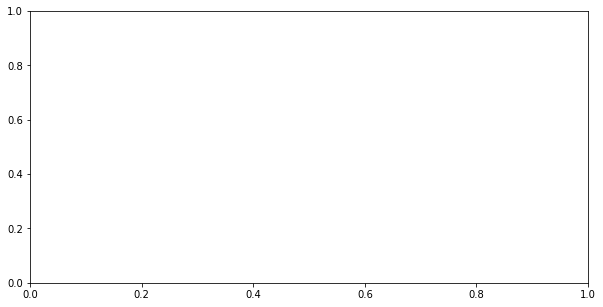

In [43]:
###################Plot the learning curve by iteration with the parameter hidden_layer_size=(5,7,7)############
# t=7
# cv = KFold(n_splits=t,shuffle=True)
AP_train_score_by_iteration=[]
AP_test_score_by_iteration=[]
training_time_by_iteration=[]
for iteration_num in range(20):
    MLP = MLPClassifier(hidden_layer_sizes=(6,5,6),activation ='tanh',solver='sgd',max_iter=10,warm_start=True)
    steps = [('under',under),('model',MLP)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['average_precision'], cv=cv, n_jobs=-1,return_train_score=True)

    training_time_by_iteration.append(sum(scores['fit_time'])/t)
    AP_train_score_by_iteration.append(sum(scores['train_average_precision'])/t)
    AP_test_score_by_iteration.append(sum(scores['test_average_precision'])/t)

##generate Fig_1.2,1, Fig_1.2.2#########
iteration_num = range(1,21)
fig_1, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
axs.plot(iteration_num,training_time_by_iteration,"r^",linestyle = "--",label="traing_time:seconds")
axs.set_xlabel("iteration_num")
axs.set_ylabel("training time")
axs.legend()
fig_1.suptitle("Fig_1.2.1:Training Time by iteration(hidden_layer_size=(5,7,7))")
fig_1.savefig("NN_fig_1.2:training_time by iteration.png")


fig_2,axs =  plt.subplots(1, 1, figsize=(10, 5), sharey=False)
axs.plot(iteration_num,AP_train_score_by_iteration,"r^",linestyle = "--", label='training data')
axs.plot(iteration_num,AP_test_score_by_iteration,"b^",linestyle = "--",label='test data')
axs.set_xlabel("iteration_num")
axs.set_ylabel("AP_score")
fig_2.suptitle('Fig_1.2.2:AP_score by iteration(hidden_layer_size=(5,7,7))')
axs.legend()
fig_2.savefig("NN_fig_1.2:AP Scores by iteration.png")



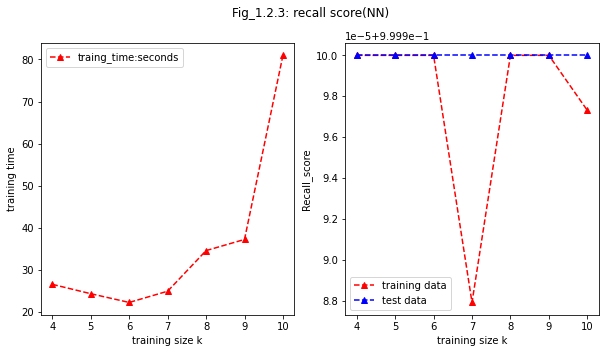

In [45]:
###############learning curves by training size################

Recall_train_score=[]
Recall_test_score=[]
training_time = []

for k in range(4,11):
    cv = KFold(n_splits=k,shuffle=True)
    MLP = MLPClassifier(hidden_layer_sizes=(5,7,7),activation ='tanh',solver='sgd',max_iter=160)
    steps = [('under',under),('model',MLP)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['recall'], cv=cv, n_jobs=-1,return_train_score=True)
    
    training_time.append(sum(scores['fit_time'])/k)
    Recall_train_score.append(sum(scores['train_recall'])/k)
    Recall_test_score.append(sum(scores['test_recall'])/k)

##genearte Fig_1.2.3 learning curves with traning size#######
K= range(4,11)
fig_3, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axs[0].plot(K,training_time,"r^",linestyle = "--",label="traing_time:seconds")
axs[0].set_xlabel("training size k")
axs[0].set_ylabel("training time")
axs[1].plot(K,Recall_train_score,"r^",linestyle = "--",label='training data')
axs[1].plot(K,Recall_test_score,"b^",linestyle = "--",label='test data')
axs[1].set_xlabel("training size k")
axs[1].set_ylabel("Recall_score")
axs[0].legend()
axs[1].legend()
fig_3.suptitle("Fig_1.2.3: recall score(NN)")
fig_3.savefig("NN_fig_1.2_trainnig:learning curves.png")

In [46]:
##################prediction results, generate the data in table1.2.0#########
cv = KFold(n_splits=4,shuffle=True)
MLP = MLPClassifier(hidden_layer_sizes=(6,5,6),activation ='tanh',solver='sgd',max_iter=160)
steps = [('under',under),('model',MLP)]
pipeline = Pipeline(steps=steps)
scores =  cross_validate(pipeline, X, y, scoring=['average_precision','recall'], cv=cv, n_jobs=-1,return_train_score=True)
print("The AP scores on training set and test set are",sum(scores['train_average_precision'])/4,sum(scores['test_average_precision'])/4)
print("The Recall scores on training set and test set are",sum(scores['train_recall'])/4,sum(scores['test_recall'])/4)


The AP scores on training set and test set are [1. 1. 1. 1.] [1. 1. 1. 1.]
The Recall scores on training set and test set are [1. 1. 1. 1.] [0.99990333 1.         1.         1.        ]
